In [2]:
from urllib.request import urlopen
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
y_train = pd.read_csv("meteorological/y_train.csv", index_col=0, parse_dates=True)
y_train.index.freq='5T'
y = pd.read_csv("meteorological/y.csv", index_col=0, parse_dates=True)
y.index.freq = '5T'

In [ ]:
n_input_target = list(set([156, 288, 576], [25, 68], [156, 288, 576]))
n_input_target.sort()
n_input_target

In [7]:
scaler = MinMaxScaler()
scaler.fit(y_train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(y_train)
scaled_test = scaler.transform(y)

In [ ]:
n_input = n_input_target[0] #순서대로 하나씩 넣어보기
n_features = 1

In [31]:

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [49]:
model = Sequential()
model.add(tf.keras.layers.LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(y)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [46]:
test_predictions

[array([0.72332144], dtype=float32),
 array([0.8512236], dtype=float32),
 array([0.79676867], dtype=float32),
 array([0.9748083], dtype=float32),
 array([1.0563692], dtype=float32),
 array([0.7824111], dtype=float32),
 array([0.9462028], dtype=float32),
 array([0.8080985], dtype=float32),
 array([0.8912762], dtype=float32),
 array([0.9375939], dtype=float32),
 array([1.015485], dtype=float32),
 array([0.6268751], dtype=float32)]

In [47]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

## Inverse Transformations and Compare

In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

In [49]:
true_predictions

array([[11493.13750124],
       [12989.46475589],
       [12352.39661551],
       [14435.28201741],
       [15389.46310055],
       [12184.42744112],
       [14100.62672776],
       [12484.94429308],
       [13458.04003853],
       [13999.91077071],
       [14911.15957999],
       [10364.81182438]])

In [50]:
y

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [51]:
# IGNORE WARNINGS
y['Predictions'] = true_predictions

C:\Users\Marcial\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
y

,Sales,Predictions
DATE,,
2018-02-01,10415,11493.137501
2018-03-01,12683,12989.464756
2018-04-01,11919,12352.396616
2018-05-01,14138,14435.282017
2018-06-01,14583,15389.463101
2018-07-01,12640,12184.427441
2018-08-01,14257,14100.626728
2018-09-01,12396,12484.944293
2018-10-01,13914,13458.040039


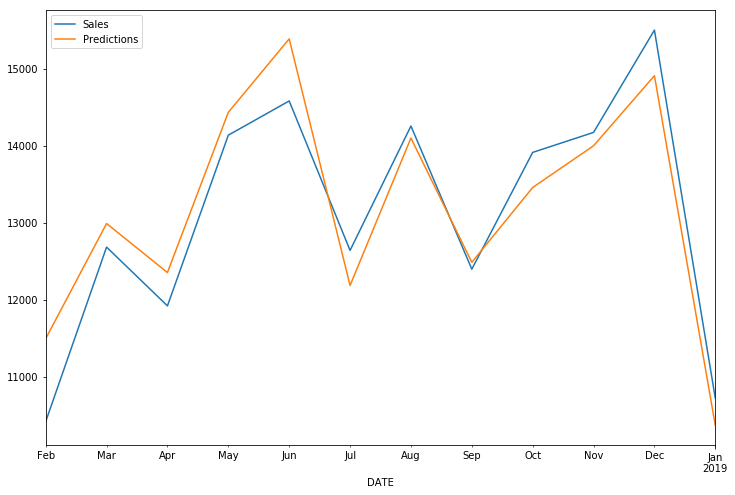

In [53]:
y.plot(figsize=(12,8))

# Saving and Loading Models

In [54]:
model.save('my_rnn_model.h5')

## load a model

In [55]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [56]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
